<a href="https://colab.research.google.com/github/sbooeshaghi/health-insurance/blob/main/healthcare_costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
def yex(ax):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, color="lightgray",linestyle="--", zorder=0)
  ax.set_aspect('equal')
  ax.set(**{
      "aspect": "equal",
      "xlim": lims,
      "ylim": lims
  })
  return ax

fsize = 20
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [2]:
# x is cumulative amount spent
def insurance_cost(x, p, d, oopm, m=1):
  return (
      p + min(oopm, 
                 min(x*m, d) + max(0, (x*m-d)*.2)
                 )# if x > d then add (x-d)*.2 max is when x is oopm
  )

In [3]:
assert insurance_cost(0, 100, 100, 10_000) == 100# 1200 = p
assert insurance_cost(100, 100, 100, 10_000) == 200 # 1300 = p + d
assert insurance_cost(120_000, 100, 100, 10_000) == 10_100 # p + 10_000 = 10_100

In [4]:
income = 70_000
tax_brackets = {
          (0,  10_275): 0.10,
     (10_276,  41_775): 0.12,
     (41_776,  89_075): 0.22,
     (89_076, 170_050): 0.24,
    (170_051, 215_950): 0.32,
    (215_951, 539_900): 0.35,
    (539_901, 9999999): 0.37,
}

def tax(income, deduction):
  t = 0
  for itv, p in tax_brackets.items():
    t += max(0, (min(income - deduction, itv[1]) - itv[0]) * p)
  return t

assert tax(income, 0) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income - 41_776)*0.22
assert tax(income, 666) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income-666 - 41_776)*0.22
assert tax(income, 1776) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income-1776 - 41_776)*0.22

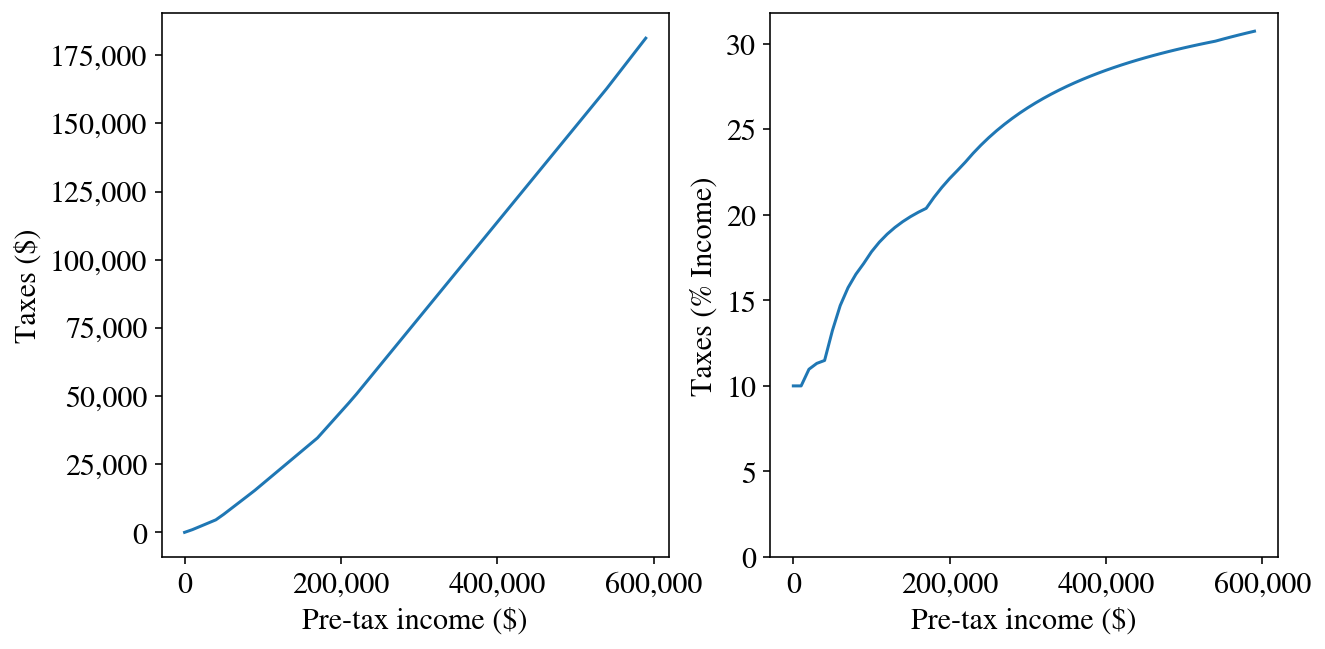

In [5]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

x = np.arange(1, 600_000, 10_000)

ax = axs[0]
y = np.array([tax(i, 0) for i in x])

ax.plot(x, y)#y/x*100)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(**{
    "xlabel": "Pre-tax income ($)",
    "ylabel": "Taxes ($)"
})

ax = axs[1]
y = y/x*100

ax.plot(x, y)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(**{
    "xlabel": "Pre-tax income ($)",
    "ylabel": "Taxes (% Income)",
    "ylim": 0
})

fig.show()

In [6]:
tax(15_000, 0), tax(40_000, 0)

(1594.38, 4594.379999999999)

In [7]:
tax(50_000, 0), tax(50_000, 1_000)

(6616.659999999999, 6396.659999999999)

In [8]:
tax(50_000, 0) - tax(50_000, 1_000)

220.0

In [9]:
(income - 666) - tax(income, 666), (income - 1776) - tax(income, 1776)

(58463.86, 57598.06)

In [10]:
(58463.86 - 57598.06)

865.8000000000029

In [52]:
plans = {
    "PPO2800": {
        "p": 54*12,
        "d": 3000,
        "oopm": 4000,
        "norm": 0,
        "color": "blue",
        "calsub": 9_089.04
    },
    "PPO1600": {
        "p": 155*12,
        "d": 1800,
        "oopm": 4000,
        "norm": tax(income, 54*12) - tax(income, 155*12),
        "color": "red",
        "calsub": 9_975.36
    },
    # "Anthem HMO,\nKaiser HMO": {
    #     "p": 163*12,
    #     "d": 1500,
    #     "oopm": 1500,
    #     "norm": 0,
    #     "color": "brown"
    # }
}

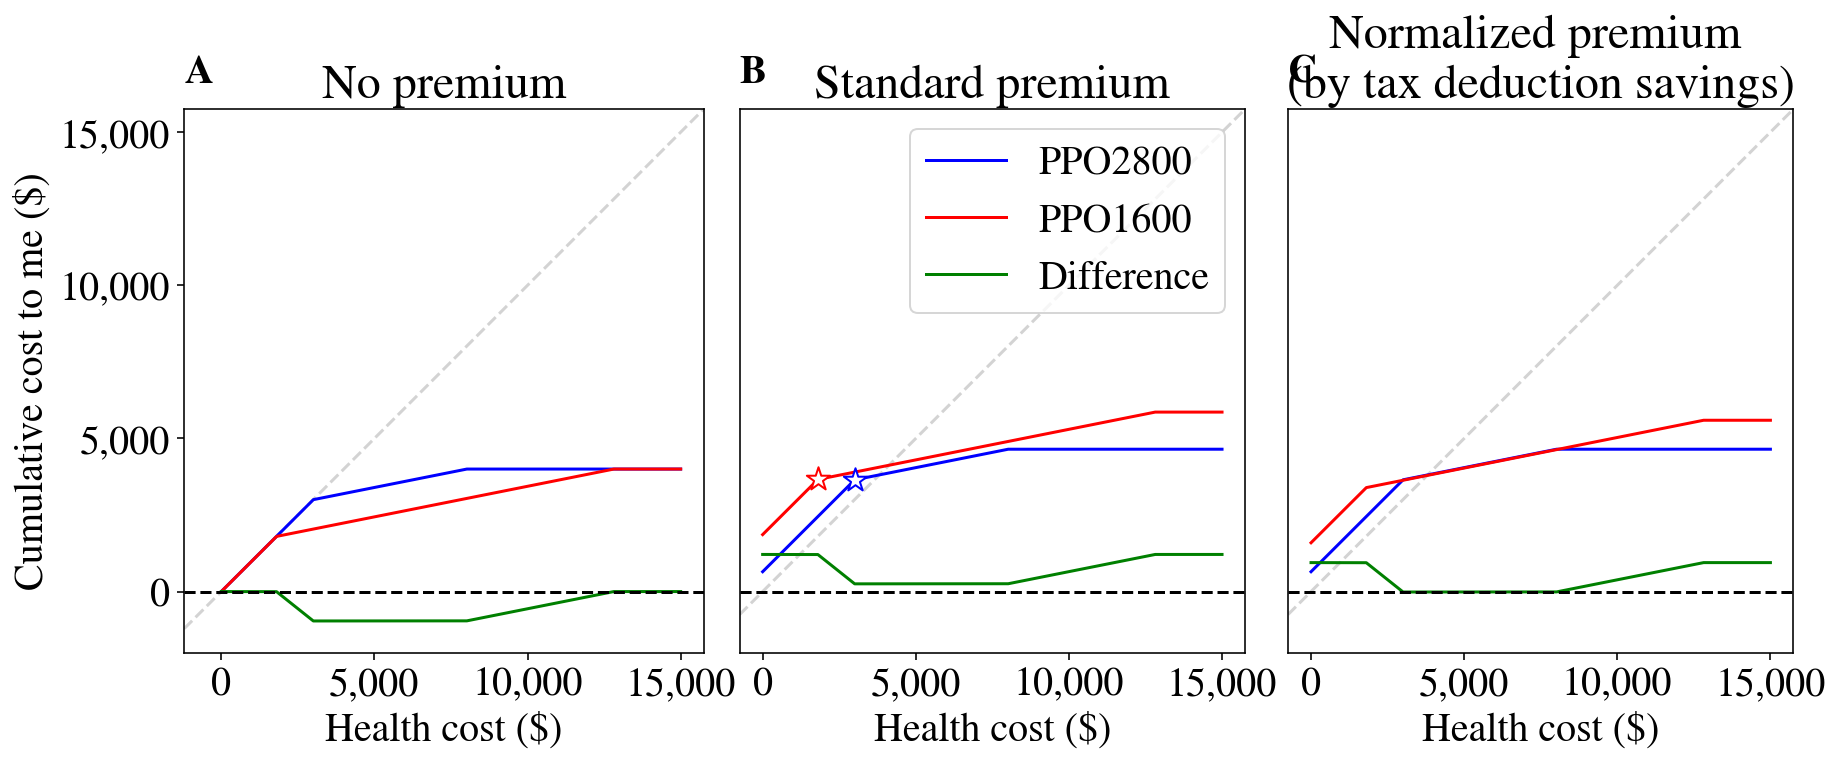

In [50]:
fig, axs = plt.subplots(figsize=(15,5), ncols=3)
fig.subplots_adjust(hspace=0, wspace=-0.05)
x = np.arange(0, 15_000)

for label, data in plans.items():
  norm = data["norm"]
  p = data["p"]
  d = data["d"]
  oopm = data["oopm"]
  norm = data["norm"]
  color = data["color"]

  y0 = np.array([insurance_cost(i, 0, d, oopm) for i in x])
  # health_cost_at_oopm = x[np.where(y == oopm + p)[0][0]]
  axs[0].plot(x, y0, label=label, color=color)

  y1 = np.array([insurance_cost(i, p, d, oopm) for i in x])
  # health_cost_at_oopm = x[np.where(y == oopm + p)[0][0]]
  axs[1].plot(x, y1, label=label, color=color)
  axs[1].scatter(d, d+p, marker="*", edgecolor=color, s=150, zorder=10, color="white")

  y2 = np.array([insurance_cost(i, p-norm, d, oopm) for i in x])
  # health_cost_at_oopm = x[np.where(y == oopm + p)[0][0]]
  axs[2].plot(x, y2, label=label, color=color)
  
  # ax.axhline(y=d+p, color=color, linestyle="--") # premium + deductible
  # ax.axvline(x=health_cost_at_oopm, color=color, linestyle="--") # health cost at oopm

  if label == "PPO2800":
    ppo2800_0 = y0
    ppo2800_1 = y1
    ppo2800_2 = y2
  elif label == "PPO1600":
    ppo1600_0 = y0
    ppo1600_1 = y1
    ppo1600_2 = y2

# # Difference
axs[0].plot(x, ppo1600_0-ppo2800_0, color="green", label="Difference") # Diff in price
axs[1].plot(x, ppo1600_1-ppo2800_1, color="green", label="Difference") # Diff in price
axs[2].plot(x, ppo1600_2-ppo2800_2, color="green", label="Difference") # Diff in price

for ax in axs:
  ax.axhline(y=0, color="black", linestyle="--")
  yex(ax)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings
axs[0].set(**{
    "xlabel": "Health cost ($)",
    "ylabel": "Cumulative cost to me ($)",
    "title": "No premium",
    "ylim": -2000
})
axs[1].set(**{
    "xlabel": "Health cost ($)",
    "yticks": [],
    "yticklabels": [],
    "title": "Standard premium",
    "ylim": -2000
})
axs[2].set(**{
    "xlabel": "Health cost ($)",
    "yticks": [],
    "yticklabels": [],
    "title": "Normalized premium \n(by tax deduction savings)",
    "ylim": -2000
})

# axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].legend()

for n, ax in enumerate(axs.flat):

    ax.imshow(np.random.randn(10,10), interpolation='none')    
    ax.text(0, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.savefig("old-healthcare.png", dpi=300)
fig.show()

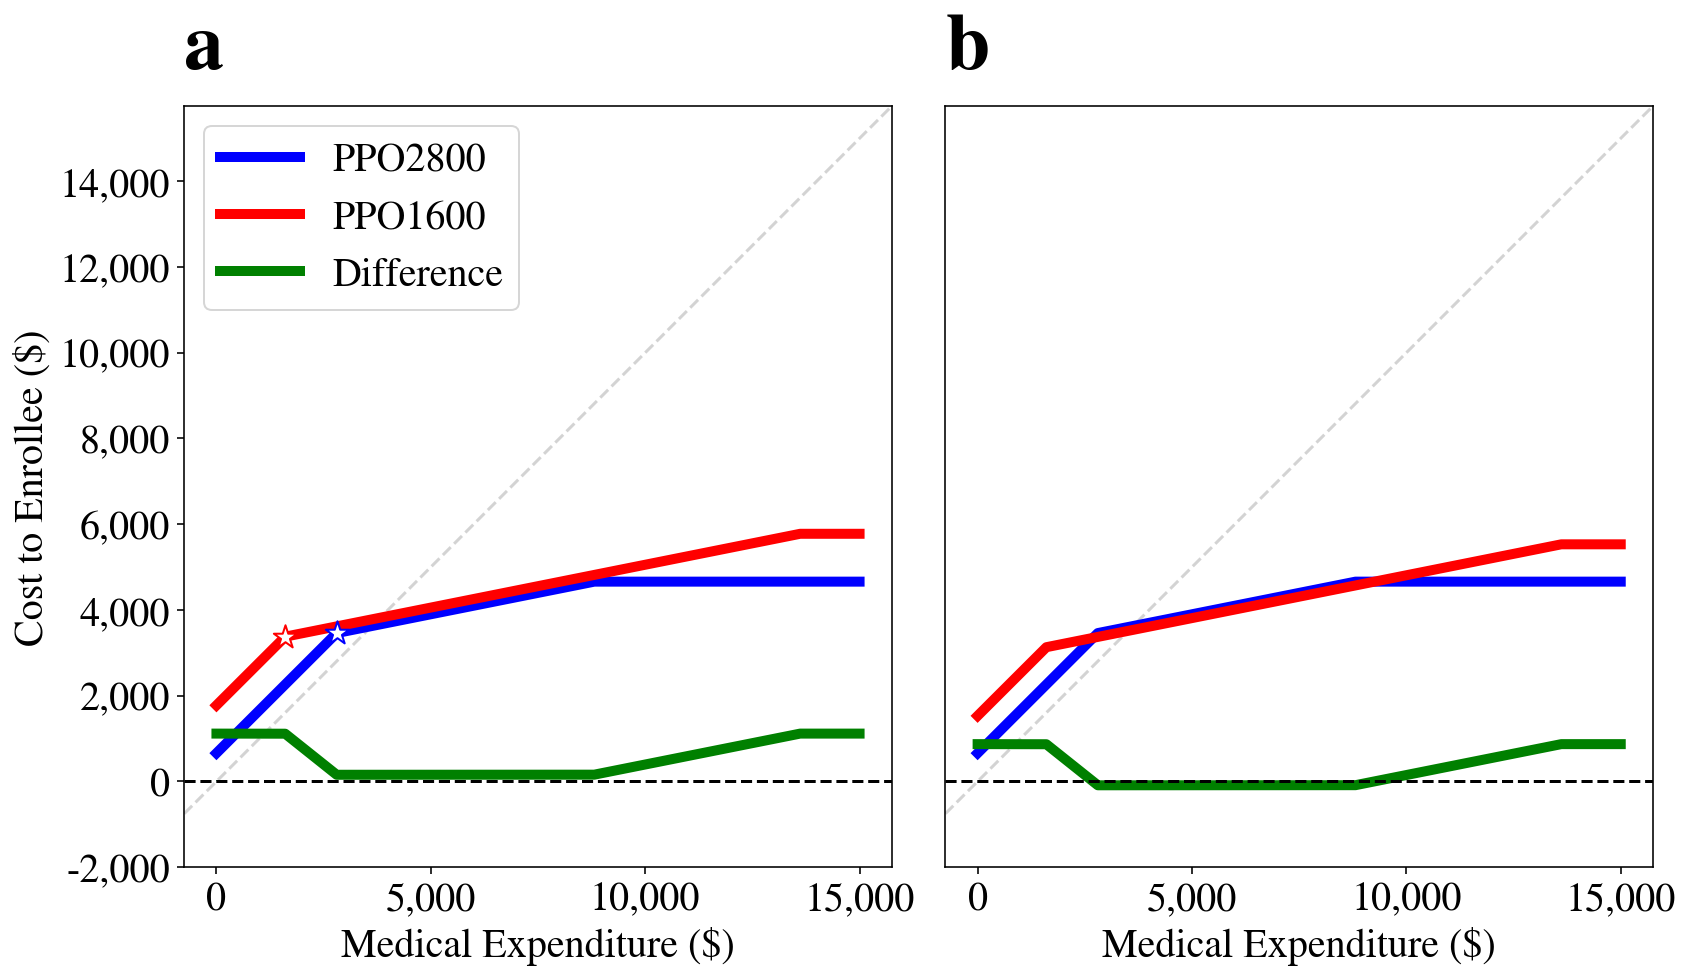

In [48]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=-0.05)
x = np.arange(0, 15_000)

for label, data in plans.items():
  norm = data["norm"]
  p = data["p"]
  d = data["d"]
  oopm = data["oopm"]
  norm = data["norm"]
  color = data["color"]


  y1 = np.array([insurance_cost(i, p, d, oopm) for i in x])
  # health_cost_at_oopm = x[np.where(y == oopm + p)[0][0]]
  axs[0].plot(x, y1, label=label, color=color, linewidth=5)
  axs[0].scatter(d, d+p, marker="*", edgecolor=color, s=150, zorder=10, color="white")

  y2 = np.array([insurance_cost(i, p-norm, d, oopm) for i in x])
  # health_cost_at_oopm = x[np.where(y == oopm + p)[0][0]]
  axs[1].plot(x, y2, label=label, color=color, linewidth=5)
  
  # ax.axhline(y=d+p, color=color, linestyle="--") # premium + deductible
  # ax.axvline(x=health_cost_at_oopm, color=color, linestyle="--") # Medical Expenditure at oopm

  if label == "PPO2800":
    ppo2800_0 = y0
    ppo2800_1 = y1
    ppo2800_2 = y2
  elif label == "PPO1600":
    ppo1600_0 = y0
    ppo1600_1 = y1
    ppo1600_2 = y2

# # Difference

axs[0].plot(x, ppo1600_1-ppo2800_1, color="green", label="Difference", linewidth=5) # Diff in price
axs[1].plot(x, ppo1600_2-ppo2800_2, color="green", label="Difference", linewidth=5) # Diff in price

for ax in axs:
  ax.axhline(y=0, color="black", linestyle="--")
  yex(ax)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

axs[0].set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee ($)",
    # "title": "No premium",
    "ylim": -2000
})
axs[1].set(**{
    "xlabel": "Medical Expenditure ($)",
    "yticks": [],
    "yticklabels": [],
    # "title": "Normalized premium \n(by tax deduction savings)",
    "ylim": -2000
})

# axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].legend()

for n, ax in enumerate(axs.flat):

    ax.imshow(np.random.randn(10,10), interpolation='none')    
    ax.text(0, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=40, weight='bold')

fig.savefig("healthcare.png", dpi=300, bbox_inches="tight")
fig.show()

In [51]:
print(f"{min(ppo1600_0-ppo2800_0):,.2f}", f"{max(ppo1600_0-ppo2800_0):,.2f}")
print(f"{min(ppo1600_1-ppo2800_1):,.2f}", f"{max(ppo1600_1-ppo2800_1):,.2f}")
print(f"{min(ppo1600_2-ppo2800_2):,.2f}", f"{max(ppo1600_2-ppo2800_2):,.2f}")


-960.00 0.00
252.00 1,212.00
-14.64 945.36


In [15]:
x[np.where(ppo1600_2-ppo2800_2 < 0)[0][0]]

2689

In [16]:
x[np.where(ppo1600_2-ppo2800_2 < 0)[0][-1]]

9247

In [17]:
# how much are you saving in taxes with a higher premium?
tax(income, 666) - tax(income, 1776)

244.20000000000073

In [18]:
tax(62_400, 0), tax(62_400, 1_000), (tax(62_400, 0) - tax(62_400, 1_000))

(9344.66, 9124.66, 220.0)

### Total premium cost

In [59]:
x1 = np.arange(0, 20_000)

data = plans["PPO1600"]
norm = data["norm"]
p = data["p"] + data["calsub"]
d = data["d"]
oopm = data["oopm"]
norm = data["norm"]
color = data["color"]


y1 = np.array([insurance_cost(i, p, d, oopm) for i in x1])

In [64]:
x1[np.where(x1 > y1)[0][0]]

15836

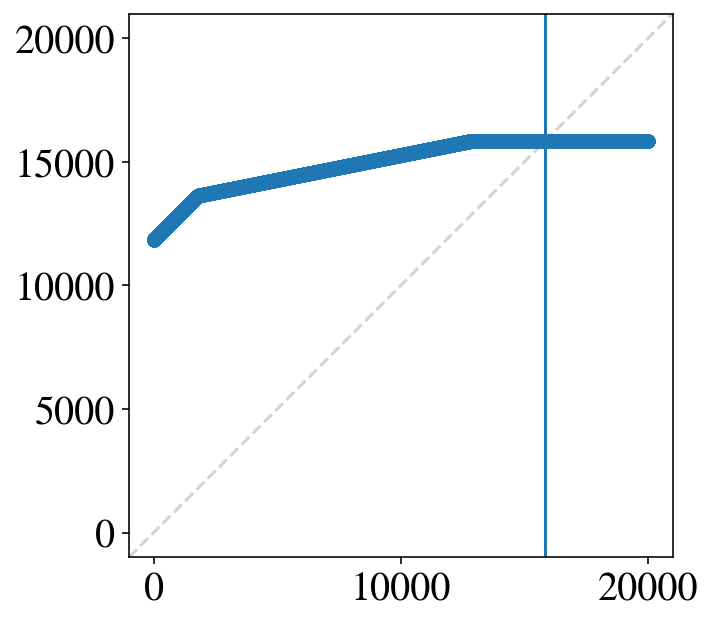

In [63]:
fig, ax = plt.subplots(figsize=(5,5))

x = x1
y = y1

ax.scatter(x,y)
ax.axvline(x=x1[np.where(x1 > y1)[0][0]])
yex(ax)
fig.show()

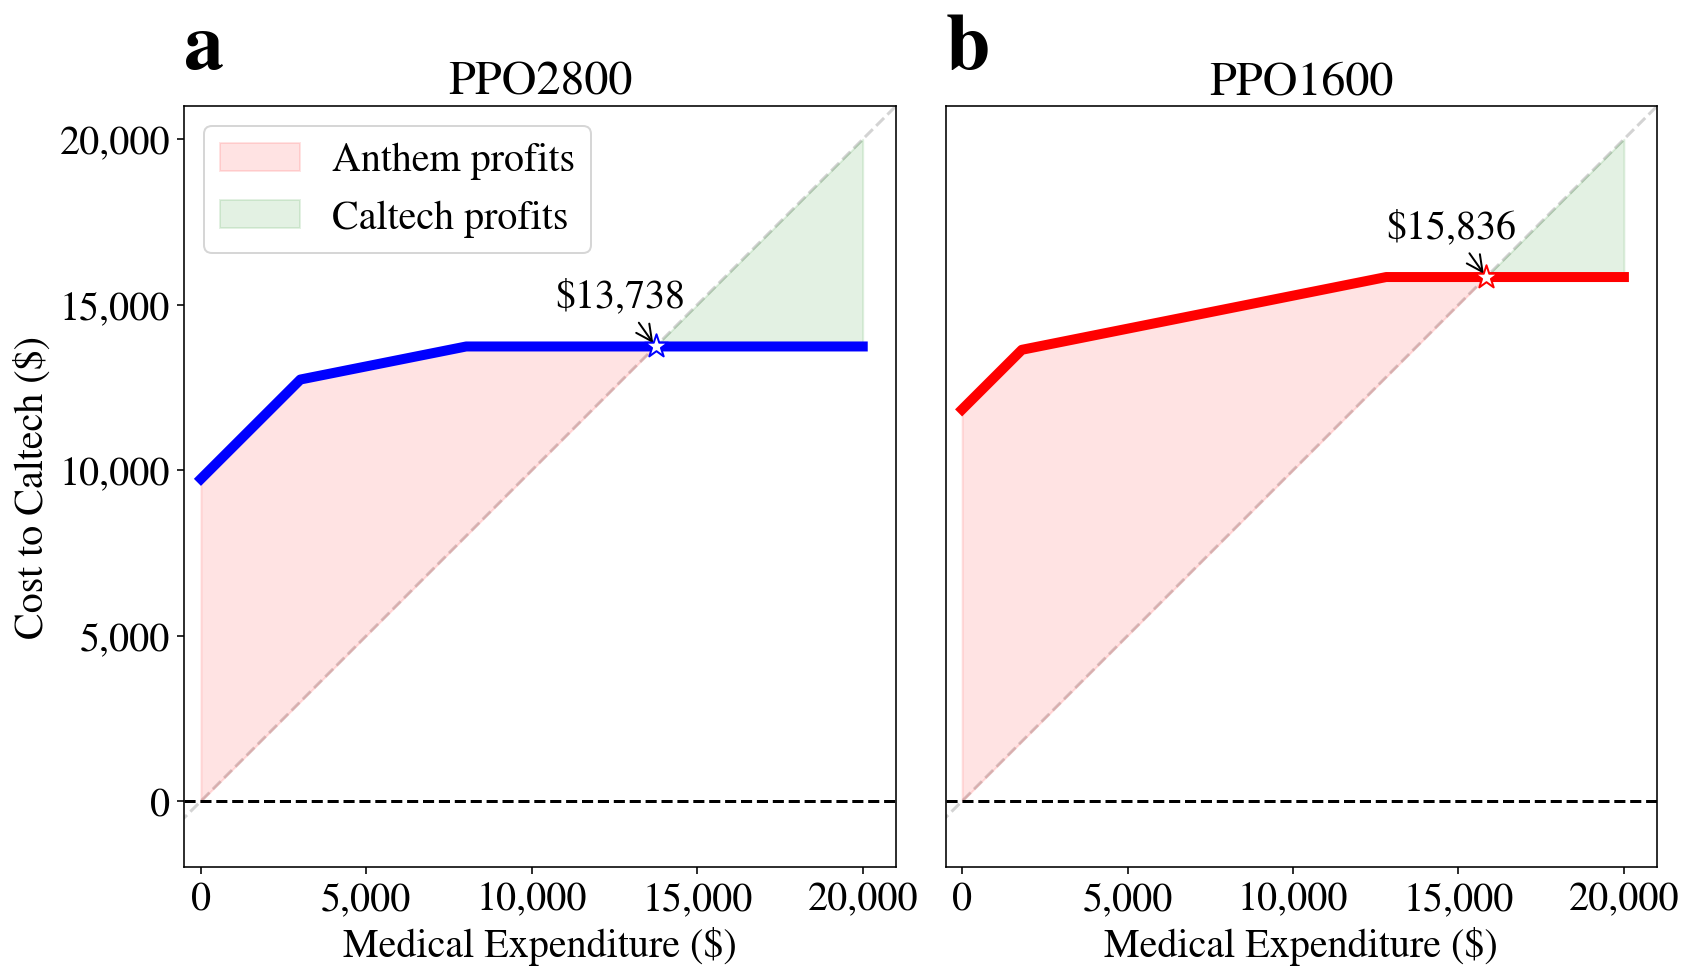

In [103]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=-0.05)
x = np.arange(0, 20_000)

ax = axs[0]
label="PPO2800"
data = plans[label]
norm = data["norm"]
p = data["p"] + data["calsub"]
d = data["d"]
oopm = data["oopm"]
norm = data["norm"]
color = data["color"]

y1 = np.array([insurance_cost(i, p, d, oopm) for i in x])
ax.plot(x, y1, color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x1[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(-50, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )
# # Difference

ax.fill_between(x[:breakevenidx], y1[:breakevenidx],x[:breakevenidx], color="red", label="Anthem profits", alpha=0.11) # Diff in price
ax.fill_between(x[breakevenidx:], y1[breakevenidx:],x[breakevenidx:], color="green", label="Caltech profits", alpha=0.11) # Diff in price

ax.axhline(y=0, color="black", linestyle="--")
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Caltech ($)",
    "title": label,
    "ylim": -2000,
    "xlim": -500
})


# axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend()

#ax.imshow(np.random.randn(10,10), interpolation='none')    
ax.text(0, 1.05, string.ascii_lowercase[0], transform=ax.transAxes, 
        size=40, weight='bold')

ax = axs[1]
label="PPO1600"
data = plans[label]
norm = data["norm"]
p = data["p"] + data["calsub"]
d = data["d"]
oopm = data["oopm"]
norm = data["norm"]
color = data["color"]

y1 = np.array([insurance_cost(i, p, d, oopm) for i in x])
ax.plot(x, y1, label=label, color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x1[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")

ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(-50, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )

# # Difference

ax.fill_between(x[:breakevenidx], y1[:breakevenidx],x[:breakevenidx], color="red", label="Anthem profits", alpha=0.11) # Diff in price
ax.fill_between(x[breakevenidx:], y1[breakevenidx:],x[breakevenidx:], color="green", label="Caltech profits", alpha=0.11) # Diff in price

ax.axhline(y=0, color="black", linestyle="--")
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    # "ylabel": "Cost to Caltech ($)",
    "title": label,
    "yticklabels": [],
    "yticks": [],
    # "title": "No premium",
    "ylim": -2000,
    "xlim": -500
})

ax.text(0, 1.05, string.ascii_lowercase[1], transform=ax.transAxes, 
        size=40, weight='bold')

fig.savefig("breakeven.png", dpi=300, bbox_inches="tight")
fig.show()

# Income assesment

In [19]:
tax_brackets

{(0, 10275): 0.1,
 (10276, 41775): 0.12,
 (41776, 89075): 0.22,
 (89076, 170050): 0.24,
 (170051, 215950): 0.32,
 (215951, 539900): 0.35,
 (539901, 9999999): 0.37}

In [20]:
lst = []
for (mn, mx), v in tax_brackets.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

In [21]:
incomes.shape

(70,)

In [22]:
x = np.arange(0, 15000)

diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO2800"]["p"]) - tax(inc, plans["PPO1600"]["p"])
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1600"]["p"]-norm, plans["PPO1600"]["d"], plans["PPO1600"]["oopm"])
    c2 = insurance_cost(i, plans["PPO2800"]["p"]     , plans["PPO2800"]["d"], plans["PPO2800"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

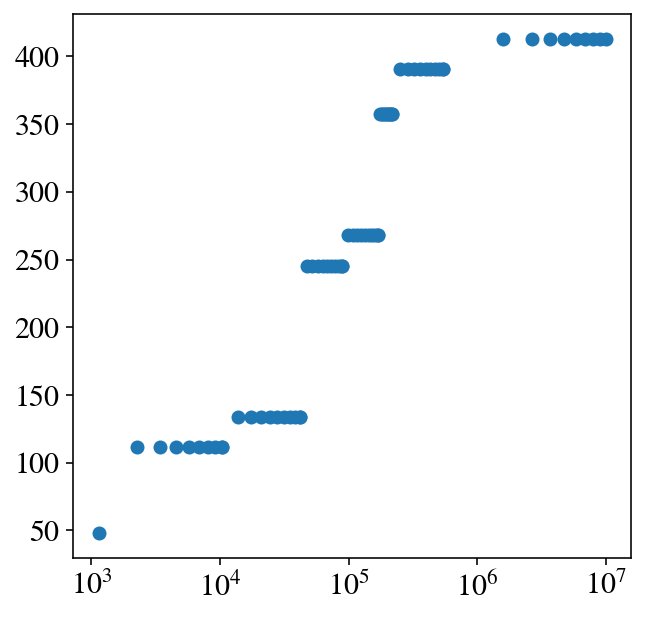

In [23]:
fig, ax = plt.subplots(figsize=(5,5))
x = incomes[1:]
y = norms[1:]

ax.scatter(x,y)
ax.set(**{
    "xscale": "symlog"
})
fig.show()

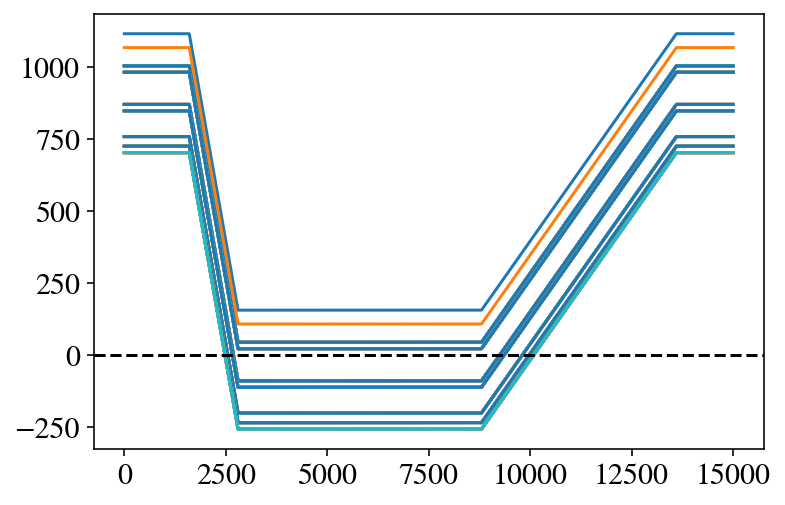

In [24]:
fig, ax = plt.subplots()

for inc, d in zip(incomes, diff):
  ax.plot(d, label=inc)

ax.axhline(0, color="k", linestyle="--")
#ax.legend()
fig.show()

In [25]:
diff.mean()

272.58790476190785

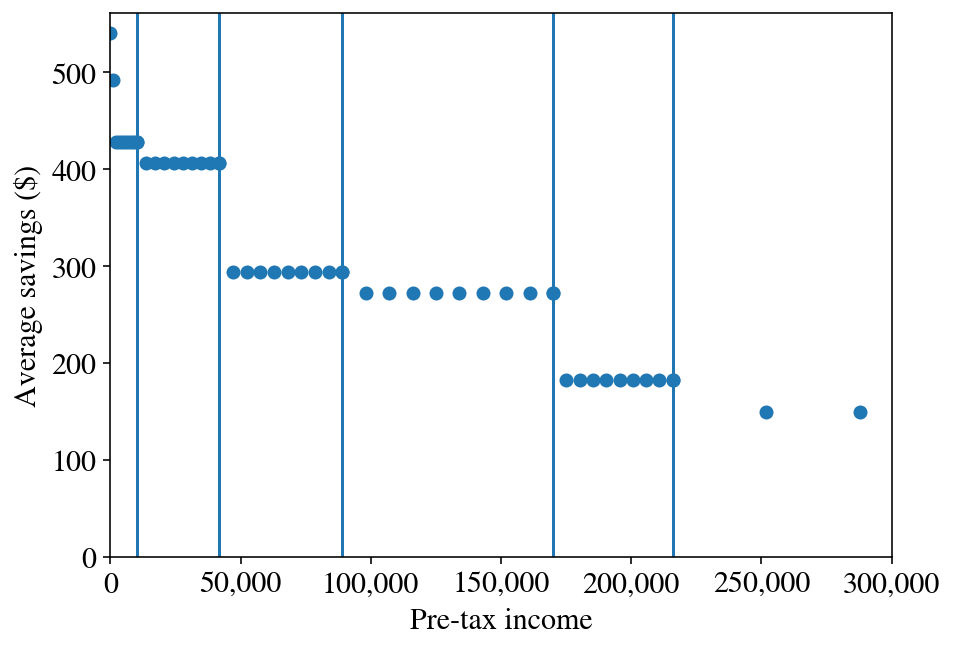

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))
x = incomes
y = diff.mean(1)

ax.scatter(x,y, label="Average savings")

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for l,h in tax_brackets.keys():
  ax.axvline(h)

ax.set(**{
    "xlabel": "Pre-tax income",
    "ylabel": "Average savings ($)",
    "ylim": 0,
    "xlim": (0, 300_000),
})
fig.show()

In [27]:
costs[1][:10]

array([[ 660.,  661.,  662., ..., 4660., 4660., 4660.],
       [ 660.,  661.,  662., ..., 4660., 4660., 4660.],
       [ 660.,  661.,  662., ..., 4660., 4660., 4660.],
       ...,
       [ 660.,  661.,  662., ..., 4660., 4660., 4660.],
       [ 660.,  661.,  662., ..., 4660., 4660., 4660.],
       [ 660.,  661.,  662., ..., 4660., 4660., 4660.]])

In [28]:
costs[0][:10]

array([[1776.        , 1777.        , 1778.        , ..., 5776.        ,
        5776.        , 5776.        ],
       [1727.83333333, 1728.83333333, 1729.83333333, ..., 5727.83333333,
        5727.83333333, 5727.83333333],
       [1664.4       , 1665.4       , 1666.4       , ..., 5664.4       ,
        5664.4       , 5664.4       ],
       ...,
       [1664.4       , 1665.4       , 1666.4       , ..., 5664.4       ,
        5664.4       , 5664.4       ],
       [1664.4       , 1665.4       , 1666.4       , ..., 5664.4       ,
        5664.4       , 5664.4       ],
       [1664.4       , 1665.4       , 1666.4       , ..., 5664.4       ,
        5664.4       , 5664.4       ]])

In [29]:
# avg min savings
(costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

array([[  61.90333333],
       [  24.312     ],
       [ -78.36      ],
       [-109.608     ],
       [-192.192     ],
       [-231.252     ],
       [-254.688     ]])

In [30]:
incomes.reshape(-1,10)

array([[0.00000000e+00, 1.14166667e+03, 2.28333333e+03, 3.42500000e+03,
        4.56666667e+03, 5.70833333e+03, 6.85000000e+03, 7.99166667e+03,
        9.13333333e+03, 1.02750000e+04],
       [1.02760000e+04, 1.37758889e+04, 1.72757778e+04, 2.07756667e+04,
        2.42755556e+04, 2.77754444e+04, 3.12753333e+04, 3.47752222e+04,
        3.82751111e+04, 4.17750000e+04],
       [4.17760000e+04, 4.70314444e+04, 5.22868889e+04, 5.75423333e+04,
        6.27977778e+04, 6.80532222e+04, 7.33086667e+04, 7.85641111e+04,
        8.38195556e+04, 8.90750000e+04],
       [8.90760000e+04, 9.80731111e+04, 1.07070222e+05, 1.16067333e+05,
        1.25064444e+05, 1.34061556e+05, 1.43058667e+05, 1.52055778e+05,
        1.61052889e+05, 1.70050000e+05],
       [1.70051000e+05, 1.75150889e+05, 1.80250778e+05, 1.85350667e+05,
        1.90450556e+05, 1.95550444e+05, 2.00650333e+05, 2.05750222e+05,
        2.10850111e+05, 2.15950000e+05],
       [2.15951000e+05, 2.51945333e+05, 2.87939667e+05, 3.23934000e+05,
   

In [31]:
(costs[0] - costs[1]).max(1).reshape(-1,10)

array([[1116.        , 1067.83333333, 1004.4       , 1004.4       ,
        1004.4       , 1004.4       , 1004.4       , 1004.4       ,
        1004.4       , 1004.4       ],
       [1004.4       ,  982.08      ,  982.08      ,  982.08      ,
         982.08      ,  982.08      ,  982.08      ,  982.08      ,
         982.08      ,  982.08      ],
       [ 982.08      ,  870.48      ,  870.48      ,  870.48      ,
         870.48      ,  870.48      ,  870.48      ,  870.48      ,
         870.48      ,  870.48      ],
       [ 870.48      ,  848.16      ,  848.16      ,  848.16      ,
         848.16      ,  848.16      ,  848.16      ,  848.16      ,
         848.16      ,  848.16      ],
       [ 848.16      ,  758.88      ,  758.88      ,  758.88      ,
         758.88      ,  758.88      ,  758.88      ,  758.88      ,
         758.88      ,  758.88      ],
       [ 758.88      ,  725.4       ,  725.4       ,  725.4       ,
         725.4       ,  725.4       ,  725.4       ,  725

In [32]:
# avg max savings
(costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

array([[1021.90333333],
       [ 984.312     ],
       [ 881.64      ],
       [ 850.392     ],
       [ 767.808     ],
       [ 728.748     ],
       [ 705.312     ]])

In [33]:
# tax brackets
list(tax_brackets.keys())

[(0, 10275),
 (10276, 41775),
 (41776, 89075),
 (89076, 170050),
 (170051, 215950),
 (215951, 539900),
 (539901, 9999999)]

In [34]:
tax_brackets

{(0, 10275): 0.1,
 (10276, 41775): 0.12,
 (41776, 89075): 0.22,
 (89076, 170050): 0.24,
 (170051, 215950): 0.32,
 (215951, 539900): 0.35,
 (539901, 9999999): 0.37}

In [35]:
# only other place I've seen this analysis http://familycarepa.com/2018-state-health-plan/